In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from utilities import lag_matrix
from torch.utils.tensorboard import SummaryWriter
from anarx import ANARX

In [10]:
writer = SummaryWriter()
total_epochs = 0

In [11]:
a = ANARX(10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(a.parameters(), lr=5e-4)



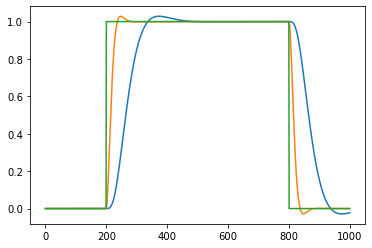

In [12]:
import control
T1 = 0.003
T2 = 0.01
D = 1.5
sysin = control.tf([1], [T1**2, D*T1, 1])
sys = control.tf([1], [T2**2, D*T2, 1])
sys2 = control.tf([1], [1])
time = np.linspace(0, .3, 1000)
u = np.concatenate((np.zeros(200), np.ones(600), np.zeros(200)))
_, yin = control.forced_response(sysin, T = time, U = u)
_, uin = control.forced_response(sys2, T = time, U = u)
_, yout = control.forced_response(sys, T = time, U = yin)
plt.plot(yout)
plt.plot(yin)
plt.plot(uin)

In [13]:
inputs = torch.from_numpy(yin)
outputs = torch.from_numpy(yout)
lagged_inputs = lag_matrix(inputs, a.nlags)


In [14]:
from tqdm import tqdm
for epoch in tqdm(range(100)):
    total_epochs = total_epochs + 1
    y_hat = torch.zeros_like(inputs)
    optimizer.zero_grad()
    lags = a.initLags()
    # Predict whole Dataset
    for i in range(len(inputs)):
        y_hat[i] = a(lagged_inputs[i], lags)
        lags = torch.roll(lags, 1, 0)
        lags[0] = y_hat[i]
    # Compute Loss and optimize
    loss = criterion(y_hat, outputs)
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    writer.add_scalar('Loss/train', loss, total_epochs)
    optimizer.step()

  2%|▏         | 2/100 [00:06<05:13,  3.20s/it]


KeyboardInterrupt: 

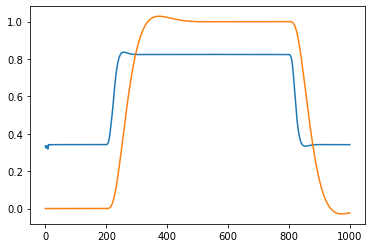

tensor(0.0755, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [ ]:
plt.plot(y_hat.detach().numpy())
plt.plot(outputs)
plt.show()
print(loss)

In [ ]:
torch.save(a, "anarxpt2.pt")